In [1]:
import pandas as pd
import numpy as np

QuestionNumber = 5  # question per page

## Functions

In [2]:
def arrange_answers(answers):    # organize answers in one instance
    arranged_answers =[[] for _ in range(QuestionNumber)]
    for name in answers.keys():
        answer = answers[name].strip().lower()    # remove sapce & convert to lower
        for i in range(QuestionNumber):
            if "answer"+str(i+1)+"-" in name:     # belong to question i
                arranged_answers[i].append(answer)
    return [list(set(t)) for t in  arranged_answers]  # remove repeated answer

In [3]:
# function relates to grading

def combine_score(preci,recall):
    return recall+0.5*preci


def preci_recall_score(anss,StandAnswer=None,RemoveZero=False):
    '''
    Calculate Precision & Recall & score for answers of one question
    Input:
    anss: All answers for one question
    StandAnswer: Standard answer; If 'None', then do not calculate the values of standard answer
    RemoveZero: Using RemoveZero method or not
    '''
    if len(anss) == 1:          # only one answer for this question
        if len(anss[0]) != 0:   # this one answer is not empty
            return [1],[1],[combine_score(1,1)]          # full score
        else:                   # this one answer is empty
            return [0],[0],[0]
    scores = []
    recalls = []
    precis = []
    for ind in range(len(anss)):
        ans = anss[ind]
        if len(ans) == 0:
            recalls.append(0)
            precis.append(0)
            scores.append(0)
        else:                   # answer not empty
            OtherAns = [anss[i] for i in range(len(anss)) if i != ind]
            OtheransSet = set([ite for eachans in OtherAns for ite in eachans])
            preci = sum([ite in OtheransSet for ite in ans])/len(ans)
            recall = sum([ite in ans for ite in OtheransSet])/len(OtheransSet)
            scores.append(combine_score(preci,recall))
            precis.append(preci)
            recalls.append(recall)
    if not RemoveZero:          # Do not remove the zero score answers in the first round
        if StandAnswer is not None:
            AllAnsSet = set([ite for eachans in anss for ite in eachans])
            stdpreci = 1.0 * (StandAnswer in AllAnsSet)
            stdrecall = sum([ite==StandAnswer for ite in AllAnsSet])/len(AllAnsSet)
            return precis,recalls,scores,[stdpreci,stdrecall,combine_score(stdpreci,stdrecall)]
        else: return precis,recalls,scores
    else:                      # remove the zero score answers in the first round
        scores2 = []
        recalls2 = []
        precis2 = []
        for ind in range(len(anss)):
            ans = anss[ind]
            if len(ans)==0 or scores[ind]==0:
                recalls2.append(0)
                precis2.append(0)
                scores2.append(0)
            else:                   # answer not empty
                OtherAns = [anss[i] for i in range(len(anss)) if (i!=ind and scores[i]!=0)]
                OtheransSet = set([ite for eachans in OtherAns for ite in eachans])
                preci = sum([ite in OtheransSet for ite in ans])/len(ans)
                recall = sum([ite in ans for ite in OtheransSet])/len(OtheransSet)
                scores2.append(combine_score(preci,recall))
                precis2.append(preci)
                recalls2.append(recall)
        if StandAnswer is not None:
            AllAns = [anss[i] for i in range(len(anss)) if scores[i]!=0]
            AllAnsSet = set([ite for eachans in AllAns for ite in eachans])
            stdpreci = 1.0 * (StandAnswer in AllAnsSet)
            stdrecall = sum([ite==StandAnswer for ite in AllAnsSet])/len(AllAnsSet)
            return precis2,recalls2,scores2,[stdpreci,stdrecall,combine_score(stdpreci,stdrecall)]
        else: return precis2,recalls2,scores2

In [4]:
def CollectAnswerInformation_Write2file(original_dataset,original_result,
                                        remove_zero=False,filename="answers_information.txt"):
    '''
    Scan the batch result file; 
    calculate Precision & Recall & Score for each answer; 
    Generate according txt file
    '''
    with open(filename,"w") as f:
        f.write(
            "# FORMAT:\n\n"+
            "VideoId :\n"+
            "Question:\n"+
            "POS_Tag :\n\n"+
            "Precision Recall Score(0.5*precision+recall) Standard Answer:\n\n"+
            "Precision Recall Score(0.5*precision+recall) [MTURK_Answer1]\n"+
            "Precision Recall Score(0.5*precision+recall) [MTURK_Answer2]\n"+
            "...\n============================================\n\n")

    answers_collect = []   # collect answers for all HITs, all answers
    size_matrix = []       # collect answer size for all HITs, all answers
    preci_matrix = []      # precision for all HITs, all answers
    recall_matrix = []     # recall for all HITs, all answers
    score_matrix = []      # scores for all HITs, all answers
    std_matrix = []        # Precision & Recall & Score for the standard answer

    # scan Batch_results & cluster answers & calculate score matrix & generate answers collection file
    last_hit_id = None

    with open(filename,"a") as f:
        for ri, (index, row) in enumerate(original_result.iterrows()):
            current_hit_id = row["HITId"]
            if (last_hit_id is not None) and (current_hit_id == last_hit_id):                              # same HIT
                line_answer = arrange_answers(eval(row["Answer.taskAnswers"])[0])
                for i in range(QuestionNumber):
                    answers[i].append(line_answer[i])
            if (last_hit_id is not None) and (current_hit_id!=last_hit_id or ri==len(original_result)-1):  # a new HIT or the Last row
                answers_collect.append(answers)
                # generate precision, recall, score, size matrix for this HIT
                hit_preci = np.zeros((len(answers[0]),QuestionNumber))  # [answers amount * question amount]
                hit_recall = np.zeros((len(answers[0]),QuestionNumber)) # [answers amount * question amount]
                hit_score = np.zeros((len(answers[0]),QuestionNumber))  # [answers amount * question amount]
                hit_size = np.zeros((len(answers[0]),QuestionNumber))   # [answers amount * question amount]
                hit_stand = np.zeros((3,QuestionNumber))                # [std preci,std recall,std score]
                for qid in range(QuestionNumber):
                    hit_preci[:,qid],hit_recall[:,qid],hit_score[:,qid],hit_stand[:,qid] = \
                    preci_recall_score(answers[qid],std_answers[qid],RemoveZero=remove_zero)
                    hit_size[:,qid] = [len(lenans) for lenans in answers[qid]]
                score_matrix.append(hit_score)
                recall_matrix.append(hit_recall)
                preci_matrix.append(hit_preci)
                size_matrix.append(hit_size)
                std_matrix.append(hit_stand)

                # write arranged answers into txt file
                for fwid in range(QuestionNumber):
                    f.write("%s\n%s\n%s\n\n"%(video_ids[fwid],video_questions[fwid],postags[fwid]))  # Question Information
                    f.write("preci  recall score\n")
                    f.write("%.3f  %.3f  %.3f  %s\n\n"%(hit_stand[0,fwid],hit_stand[1,fwid],         # Standard Answer Information
                                                         hit_stand[2,fwid],std_answers[fwid]))
                    for canid in range(len(answers[fwid])):                                          # Workers Answers Information
                        f.write('%.3f  %.3f  %.3f  %s\n' %(hit_preci[canid,fwid],hit_recall[canid,fwid],
                                                           hit_score[canid,fwid],str(answers[fwid][canid])))
                    f.write("============================================\n\n")                    
            if  last_hit_id == None or current_hit_id!=last_hit_id:              # collect information & answers for the new HIT
                last_hit_id = current_hit_id
                video_ids = [row["Input.video"+str(wid)+"_id"] for wid in range(1,QuestionNumber+1)]
                video_questions = [row["Input.question"+str(wid)] for wid in range(1,QuestionNumber+1)]
                postags = [row["Input.pos_tag"+str(wid)] for wid in range(1,QuestionNumber+1)]
                std_answers = [original_dataset[(original_dataset.video_id==video_ids[wid]) 
                                                & (original_dataset.question==video_questions[wid])
                                               ]["answer"].iloc[0] for wid in range(QuestionNumber)]
                answers = [[] for _ in range(QuestionNumber)]                    # answers for one HIT
                line_answer = arrange_answers(eval(row["Answer.taskAnswers"])[0])
                for i in range(QuestionNumber):
                    answers[i].append(line_answer[i])
    return answers_collect,preci_matrix,recall_matrix,score_matrix,size_matrix,std_matrix

## Calculate Answers Information

In [5]:
original_result = pd.read_csv("Batch_4058534_batch_results.csv")
original_dataset = pd.read_csv("val1.csv") # look for standard answer

In [6]:
answers_collect,preci_matrix,recall_matrix,score_matrix,size_matrix,std_matrix = \
    CollectAnswerInformation_Write2file(original_dataset,original_result,
                                        remove_zero=False,filename="answers_information.txt")             # Not remove zero method
answers_collect2,preci_matrix2,recall_matrix2,score_matrix2,size_matrix2,std_matrix2 = \
    CollectAnswerInformation_Write2file(original_dataset,original_result,
                                        remove_zero=True,filename="answers_remove_zero_information.txt")  # Remove zero method

## Answers Statistics & Plots

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

### Answer Level

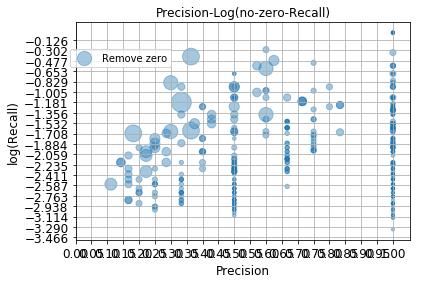

In [8]:
## preci-recall plot
all_preci1 = [ite3 for ite1 in preci_matrix for ite2 in ite1 for ite3 in ite2]
all_recall1 = [ite3 for ite1 in recall_matrix for ite2 in ite1 for ite3 in ite2]
all_size1 = [ite3 for ite1 in size_matrix for ite2 in ite1 for ite3 in ite2]

all_preci2 = [ite3 for ite1 in preci_matrix2 for ite2 in ite1 for ite3 in ite2]
all_recall2 = [ite3 for ite1 in recall_matrix2 for ite2 in ite1 for ite3 in ite2]
all_size2 = [ite3 for ite1 in size_matrix2 for ite2 in ite1 for ite3 in ite2]

# plot
# X1 = all_preci1
# X2 = all_preci2
# Y1 = all_recall1
# Y2 = all_recall2
# S1 = all_size1
# S2 = all_size2

X1 = [all_preci1[i] for i in range(len(all_recall1)) if all_recall1[i]!=0]
X2 = [all_preci2[i] for i in range(len(all_recall2)) if all_recall2[i]!=0]
Y1 = np.log([i for i in all_recall1 if i!=0])
Y2 = np.log([i for i in all_recall2 if i!=0])
S1 = [all_size1[i] for i in range(len(all_recall1)) if all_recall1[i]!=0]
S2 = [all_size2[i] for i in range(len(all_recall1)) if all_recall2[i]!=0]

plt.scatter(X2,Y2,s=7*np.power(1.4,S2),alpha=0.4,label="Remove zero")
# plt.scatter(X1,Y1,s=7*np.power(1.4,S1),alpha=0.6,label="Do not remove zero")
plt.xticks(np.arange(0,1.05,0.05),fontsize=12)
plt.yticks(np.arange(min(Y1),max(Y2)+0.05,(max(Y2)+0.05-min(Y1))/20),fontsize=12)
plt.grid()
plt.title("Precision-Log(no-zero-Recall)")
# plt.title("Precision-Recall")
plt.legend(bbox_to_anchor=(0.3,0.90))
plt.xlabel("Precision",fontsize=12)
plt.ylabel("log(Recall)",fontsize=12)
# plt.ylabel("Recall",fontsize=12)
plt.show()

### Instance Level

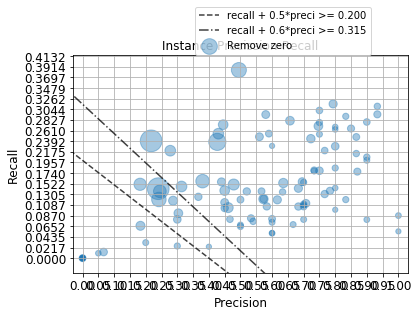

In [9]:
instance_preci_mean_matrix = [np.mean(ite,axis=1) for ite in preci_matrix2]
instance_recall_mean_matrix = [np.mean(ite,axis=1) for ite in recall_matrix2]
instance_size_mean_matrix = [np.mean(ite,axis=1) for ite in size_matrix2]
all_instance_preci_mean = [ite2 for ite1 in instance_preci_mean_matrix for ite2 in ite1]
all_instance_recall_mean = [ite2 for ite1 in instance_recall_mean_matrix for ite2 in ite1]
all_instance_size_mean = [ite2 for ite1 in instance_size_mean_matrix for ite2 in ite1]

X = all_instance_preci_mean
Y = all_instance_recall_mean
plt.scatter(X,Y,s=20*np.power(1.4,all_instance_size_mean),alpha=0.4,label="Remove zero")
plt.xticks(np.arange(0,1.05,0.05),fontsize=12)
plt.yticks(np.arange(min(Y),max(Y)+0.05,(max(Y)+0.05-min(Y))/20),fontsize=12)
plt.grid()

# potential dividing line
xps = np.arange(-0.1,1,0.01)
yps1 = -0.5*xps+0.2
yps2 = -0.6*xps+0.315
plt.plot(xps,yps1,c="k",linestyle="--",alpha=0.75,label="recall + 0.5*preci >= 0.200")
plt.plot(xps,yps2,c="k",linestyle="-.",alpha=0.75,label="recall + 0.6*preci >= 0.315")

plt.ylim(min(Y)-0.03,max(Y)+0.03)
plt.xlim(min(X)-0.03,max(X)+0.03)

plt.title("Instance Precission-Recall")
plt.legend(bbox_to_anchor=(0.35,0.98))
plt.xlabel("Precision",fontsize=12)
plt.ylabel("Recall",fontsize=12)
plt.show()

### Worker Level

In [10]:
# link worker to his/her answers
worker_answer_dict = dict()
for ind in range(len(original_result["WorkerId"])):
    wid = original_result["WorkerId"][ind]
    if wid in worker_answer_dict:
        worker_answer_dict[wid].append(ind)
    else:
        worker_answer_dict[wid]=[ind]

Worker question amount mean: 1.8 questions/worker
Worker question amount std_error: 1.6 questions/worker


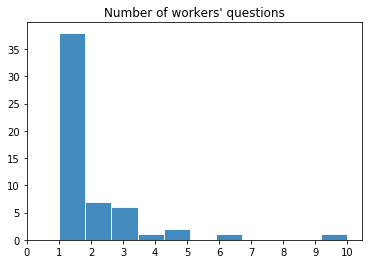

In [11]:
# statistics of answers amount the workers provide
worker_question_amount = [len(ite) for ite in worker_answer_dict.values()]
print("Worker question amount mean: %.1f questions/worker"%np.mean(worker_question_amount))
print("Worker question amount std_error: %.1f questions/worker"%np.std(worker_question_amount))
plt.hist(worker_question_amount,11,alpha=0.85,edgecolor="white")
plt.xticks(range(0,11,1))
plt.title("Number of workers' questions")
plt.show()

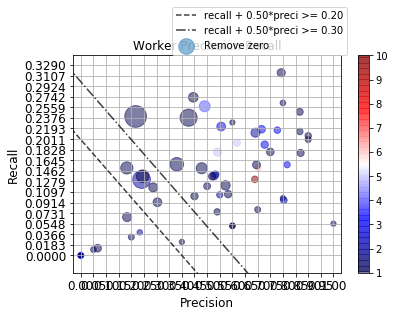

In [12]:
# worker's precission - recall
workers_preci = []
workers_recall = []
workers_len = []
for worker_answers in worker_answer_dict.values():
    workers_preci.append(np.mean(np.array(all_instance_preci_mean)[worker_answers]))
    workers_recall.append(np.mean(np.array(all_instance_recall_mean)[worker_answers]))
    workers_len.append(np.mean(np.array(all_instance_size_mean)[worker_answers]))

X = workers_preci
Y = workers_recall
plt.scatter(X,Y,s=20*np.power(1.4,workers_len),alpha=0.5,label="Remove zero",c=worker_question_amount,cmap="seismic")
plt.xticks(np.arange(0,1.05,0.05),fontsize=12)
plt.yticks(np.arange(min(Y),max(Y)+0.05,(max(Y)+0.05-min(Y))/20),fontsize=12)
plt.colorbar()
plt.grid()

# potential dividing line
xps = np.arange(-0.1,1,0.01)
yps1 = -0.5*xps+0.2
yps2 = -0.5*xps+0.3
plt.plot(xps,yps1,c="k",linestyle="--",alpha=0.75,label="recall + 0.50*preci >= 0.20")
plt.plot(xps,yps2,c="k",linestyle="-.",alpha=0.75,label="recall + 0.50*preci >= 0.30")

plt.ylim(min(Y)-0.03,max(Y)+0.03)
plt.xlim(min(X)-0.03,max(X)+0.03)

plt.title("Worker Precission-Recall")
# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(0.35,0.98))
plt.xlabel("Precision",fontsize=12)
plt.ylabel("Recall",fontsize=12)

plt.show()

### Time Level

Work time mean: 4.7 min/question
Work time std_error: 5.4 min/question


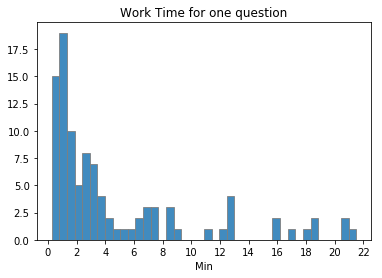

In [13]:
## time statistics
print("Work time mean: %.1f min/question"%(np.mean(original_result["WorkTimeInSeconds"]/60/QuestionNumber)))
print("Work time std_error: %.1f min/question"%(np.std(original_result["WorkTimeInSeconds"]/60/QuestionNumber)))
plt.hist((original_result["WorkTimeInSeconds"]/60/QuestionNumber),40,alpha=0.85,edgecolor="grey")
plt.xticks(range(0,23,2))
plt.xlabel("Min")
plt.title("Work Time for one question")
plt.show()

### Question Level

question words mean: 3.0 words/question
question words std_error: 0.7 words/quesiton


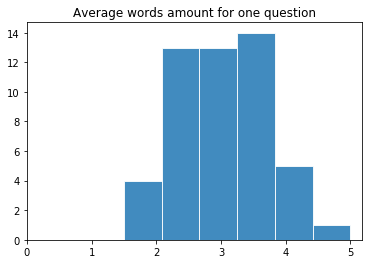

In [14]:
# question size statistics
question_words_mean_matrix = [np.mean(ite,axis=0) for ite in size_matrix2]
all_question_words_mean = [ite2 for ite1 in question_words_mean_matrix for ite2 in ite1]
print("question words mean: %.1f words/question"%np.mean(all_question_words_mean))
print("question words std_error: %.1f words/quesiton"%np.std(all_question_words_mean))
plt.hist(all_question_words_mean,6,alpha=0.85,edgecolor="white")
plt.xticks(range(0,6,1))
plt.title("Average words amount for one question")
plt.show()

question preci mean: 0.6 /question
question preci std_error: 0.2 /quesiton


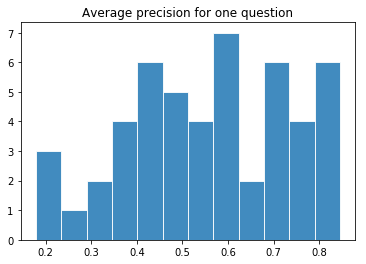

In [15]:
# question precision statistics
question_preci_mean_matrix = [np.mean(ite,axis=0) for ite in preci_matrix2]
all_question_preci_mean = [ite2 for ite1 in question_preci_mean_matrix for ite2 in ite1]
print("question preci mean: %.1f /question"%np.mean(all_question_preci_mean))
print("question preci std_error: %.1f /quesiton"%np.std(all_question_preci_mean))
plt.hist(all_question_preci_mean,12,alpha=0.85,edgecolor="white")
# plt.xticks(range(0,1,0.2))
plt.title("Average precision for one question")
plt.show()

question recall mean: 0.1 /question
question recall std_error: 0.1 /quesiton


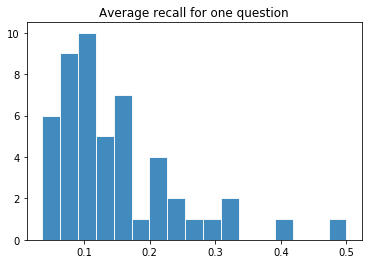

In [16]:
# question recall statistics
question_recall_mean_matrix = [np.mean(ite,axis=0) for ite in recall_matrix2]
all_question_recall_mean = [ite2 for ite1 in question_recall_mean_matrix for ite2 in ite1]
print("question recall mean: %.1f /question"%np.mean(all_question_recall_mean))
print("question recall std_error: %.1f /quesiton"%np.std(all_question_recall_mean))
plt.hist(all_question_recall_mean,17,alpha=0.85,edgecolor="white")
# plt.xticks(range(0,1,0.2))
plt.title("Average recall for one question")
plt.show()

### Standard Answer Level

In [17]:
all_std_answer_preci = [ite2 for ite1 in std_matrix2 for ite2 in ite1[0,:]]
print("%d/%d standard answers appear in workers' answers"%(sum(all_std_answer_preci),len(all_std_answer_preci)))

39/50 standard answers appear in workers' answers


## Generate Review Files

### Instance Review Result txt

In [38]:
lower_approve = np.array(all_instance_recall_mean)+0.5*np.array(all_instance_preci_mean) >= 0.2
upper_approve = np.array(all_instance_recall_mean)+0.6*np.array(all_instance_preci_mean) >= 0.315

In [41]:
last_HIT= None
with open("Review_result.txt","w") as f:
    f.write("Appr: Recall + 0.6*Precision >= 0.315\n"+
           "Reje: Recall + 0.5*Precision < 0.2\n"+
           "Midd: In the middle\n\n")
    for ite in range(len(original_result)):
        curr_hit = original_result.iloc[ite]["HITId"]
        if last_HIT is None:        # first HIT
            f.write("HITId: %s\n"%curr_hit)
        elif last_HIT != curr_hit:  # New HIT
            f.write("\n\nHITId: %s\n"%curr_hit)
        if (last_HIT is None) or (last_HIT != curr_hit):  # print standard answers
            f.write("Standard answers: ")
            row = original_result.iloc[ite]
            video_ids = [row["Input.video"+str(wid)+"_id"] for wid in range(1,QuestionNumber+1)]
            video_questions = [row["Input.question"+str(wid)] for wid in range(1,QuestionNumber+1)]
            std_answers = [original_dataset[(original_dataset.video_id==video_ids[wid]) 
                                                & (original_dataset.question==video_questions[wid])
                                               ]["answer"].iloc[0] for wid in range(QuestionNumber)]
            f.write("%s\n"%str(std_answers))
        if upper_approve[ite]:        # approve
            f.write("Appr   ")
        elif lower_approve[ite]:      # middle
            f.write("Midd   ")
        else:                         # reject
            f.write("Reje   ")
        f.write(str(original_result.iloc[ite]["Answer.taskAnswers"]))
        f.write("\n")
        last_HIT = curr_hit

### Mturk Review CSV

In [18]:
instacne_sores = np.array(all_instance_recall_mean)+0.5*np.array(all_instance_preci_mean)
approval_sign = instacne_sores >= 0.2
approve_marks = []
reject_marks = []
for ite in approval_sign:
    if ite:                # approve
        approve_marks.append("x")
        reject_marks.append("")
    else:                  # reject
        approve_marks.append("")
        reject_marks.append("Thank you for your answer! " +
                            "But We are sorry to say that this answer is rejected "+
                            "because it is inaccurate or incomprehensive."+
                            " Please read the instructions at first.")
        
original_result["Approve"] = approve_marks
original_result["Reject"] = reject_marks

In [19]:
original_result.to_csv("Batch_review.csv",index=False)